# Modelling 1d poisson problem using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

### Manufactured solution


We use $u = sin(x)$ for $x\in [0,4]$ to manufacture the right hand side to be $f=sin(x)$

### Importing packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [63]:
np.random.seed(123)
X_tr_pde = np.random.uniform(0,2*np.pi,1000).reshape(1000,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

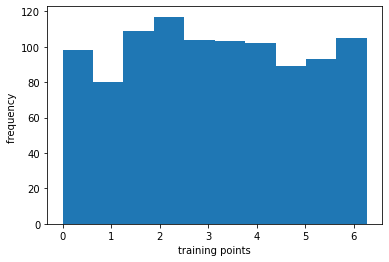

In [64]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

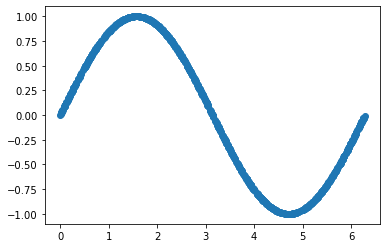

In [65]:
Y_tr_pde = np.sin(X_tr_pde)
plt.scatter(X_tr_pde,Y_tr_pde)

In [66]:
X_tr_Dr_bc_left = np.zeros(100).reshape(100,1)
X_tr_Dr_bc_right = 2*np.pi*np.ones(100).reshape(100,1)

Y_tr_Dr_bc_left = np.sin(0.)*(X_tr_Dr_bc_left)
Y_tr_Dr_bc_right = np.sin(X_tr_Dr_bc_right)


In [67]:
X_tr = np.concatenate((X_tr_pde, X_tr_Dr_bc_left,
                       X_tr_Dr_bc_right), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_Dr_bc_left,
                      Y_tr_Dr_bc_right), axis=0)

## Training the model 

### Defining Keras layers

In [68]:
#definng the first input layer
input_ = keras.layers.Input(shape=X_tr.shape[1:],name="input_layer")
#defining two deep layers in the deep network starting with input_B
hidden_1 = keras.layers.Dense(40, activation="tanh")(input_)
hidden_01 = keras.layers.Dense(40, activation="tanh")(hidden_1)
hidden_2 = keras.layers.Dense(40, activation="tanh")(hidden_01)
#Final value of function
output_u = keras.layers.Dense(1, name="func_u")(hidden_2)
#Defining the first derrivative in terms of a lambda layer
# output_pde = keras.layers.Lambda(lambda x: tf.gradients(x,input_)[0]) (output_u)
#Defining the second derrivative in terms of another lambda layer
# output_pde_2 = keras.layers.Lambda(lambda x: tf.gradients(x,input_)[0]) (output_pde)

# #combining the original output u and its hessian
# output_u_pde = keras.layers.Concatenate()([output_u, output_pde_2])

#Finally defining the model using functional api
# pinn_model = keras.Model(inputs=[input_], outputs=[output_u, output_pde_2])
pinn_model = keras.Model(inputs=[input_], outputs=[output_u])
pinn_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 40)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
func_u (Dense)               (None, 1)                 41        
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________


### Defining custom loss function

In [69]:
def custom_loss_bc(y_true, y_pred):
        error = y_true - y_pred
        is_bc_point = tf.abs(y_true) < 10e-6
        bc_error = 0.5*(y_true **2)
        no_error = tf.zeros(y_true.shape)
        return tf.where(is_bc_point, bc_error, no_error)

In [70]:
def custom_loss_pde(y_true, y_pred):
    error = y_true - y_pred
    is_inside_point = tf.abs(y_true) > 10e-6
    pde_error = 0.5*error**2
    no_error = tf.zeros(y_true.shape)
    return tf.where(is_inside_point, pde_error, no_error)

In [78]:
pinn_model.compile(loss=["mse"], optimizer=keras.optimizers.SGD(lr=1e-2)
                  )

In [83]:
history = pinn_model.fit(X_tr_pde,Y_tr_pde, epochs=200)

Epoch 1/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 11/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 12/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 13/200
32/32 [=================

32/32 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 103/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 104/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 105/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 106/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 107/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 108/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 109/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 110/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 111/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 112/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 113/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 114/200
32/32 [=========

32/32 [==============================] - 0s 3ms/step - loss: 7.8674e-04


In [85]:
pinn_model.compile(loss=["mse"], optimizer=keras.optimizers.SGD(lr=1e-4)
                  )

In [90]:
history_2 = pinn_model.fit(X_tr_pde,Y_tr_pde, epochs=50)

Epoch 1/50
32/32 [==============================] - 0s 4ms/step - loss: 3.4635e-04
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4626e-04
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4621e-04
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4641e-04
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4609e-04
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4615e-04
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4598e-04
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 3.4644e-04
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 3.4604e-04
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 3.4602e-04
Epoch 11/50
32/32 [==============================] - 0s 4ms/step - loss: 3.4615e-04
Epoch 12/50
32/32 [==============================] - 0s 3ms/step - loss: 3.4601e-04
E

In [91]:
X_test = np.random.uniform(0,2*np.pi,500).reshape((500,1))

In [92]:
Y_test = pinn_model.predict(X_test)

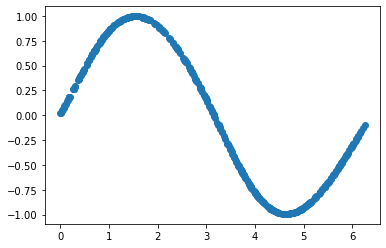

In [93]:
plt.scatter(X_test,Y_test)